# Impact of resolution and numeric schemas over trajectories predictions quality

In [1]:
import numpy as np
import xarray as xr
from math import *
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import pyplot as plt

import stagem1.temporal_integration as sti
import stagem1.int_temp_integration as iti
import xsimlab as xs
from scipy.stats import norm
import seaborn as sns

In [4]:
x=iti.SetUp()
y=sti.SetUp()
x.out_ds

<xarray.Dataset>
Dimensions:                 (a: 100, otime: 143, t: 150, time: 144, x: 410)
Coordinates:
  * a                       (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime                   (otime) int64 0 3600 7200 ... 504000 507600 511200
  * t                       (t) float64 -7.2e+03 -3.6e+03 ... 5.292e+05
  * time                    (time) int64 0 3600 7200 ... 507600 511200 514800
  * x                       (x) float64 -1.037e+05 -1.027e+05 ... 3.053e+05
    otime_day               (otime) float64 0.0 0.04167 0.08333 ... 5.875 5.917
    t_day                   (t) float64 -0.08333 -0.04167 0.0 ... 6.083 6.125
    x_km                    (x) float64 -103.7 -102.7 -101.7 ... 304.3 305.3
Data variables: (12/23)
    init__N                 int64 100
    init__maxi              float64 2e+05
    init__mini              int64 0
    position__p             (otime, a) float64 0.0 2.02e+03 ... 2.517e+05
    v_field__advected       int64 1
    v_field__k              float64 6.283e-05
    ...                      ...
    position_km             (otime, a) float64 0.0 2.02 4.04 ... 249.6 251.7
    displacement            (otime, a) float64 0.0 0.0 ... 5.163e+04 5.17e+04
    displacement_km         (otime, a) float64 0.0 0.0 0.0 ... 51.58 51.63 51.7
    velocity_field          (t, x) float64 0.1652 0.1603 ... 0.09121 0.08498
    diff_acc                (otime, a) float64 -3.911e-07 ... 1.404e-05
    CFL                     float64 0.72

# Visualisation of trajectories
### Unadvected case bilinear interpolation

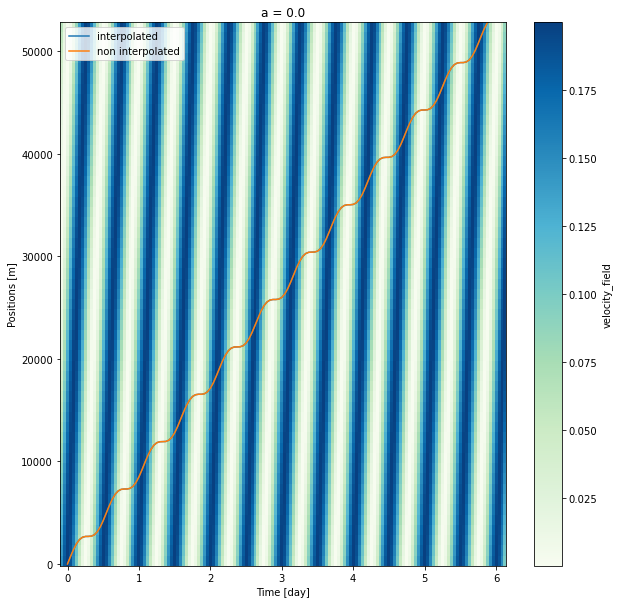

In [5]:
plt.figure(figsize=(10,10))
x=iti.SetUp(advected=0)
y=sti.SetUp(advected=0)
px_selec=x['p'].isel(a=0)
x['VF'].where(x.out_ds.x< px_selec.max(), drop=True).where(x.out_ds.x>px_selec.min(),drop=True).plot(x='t_day',cmap='GnBu')

px_selec.plot(x='otime_day', label='interpolated')
y['p'].isel(a=0).plot(x='otime_day', label='non interpolated')
plt.legend()
propagation=np.ones_like(y['otime'])*y['w']/y['k']+y['um']
mean=y['p'].isel(otime=-1, a=-1).values/2
plt.plot(y.out_ds.otime_day,propagation*y['otime']+mean,  label='w/k',lw=3)

Difference between uninterpolated/interpolated trajectories

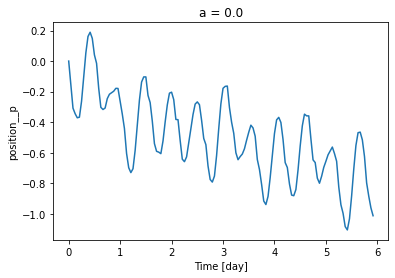

In [6]:
(x['p']-y['p']).isel(a=0).plot(x='otime_day')

### Advected case Lagrange interpolation

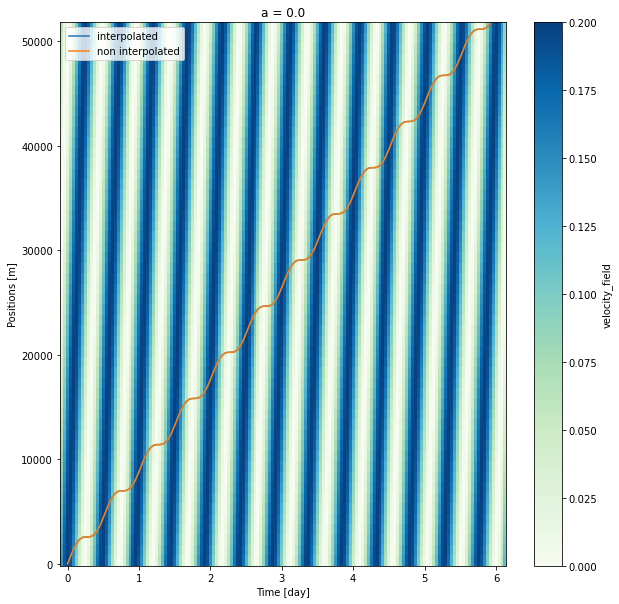

In [7]:
plt.figure(figsize=(10,10))
x=iti.SetUp(inter_method='lagrange')
y=sti.SetUp()
px_selec=x['p'].isel(a=0)
x['VF'].where(x.out_ds.x< px_selec.max(), drop=True).where(x.out_ds.x>px_selec.min(),drop=True).plot(x='t_day',cmap='GnBu')

px_selec.plot(x='otime_day', label='interpolated')
y['p'].isel(a=0).plot(x='otime_day', label='non interpolated')
plt.legend()
propagation=np.ones_like(y['otime'])*y['w']/y['k']+y['um']
mean=y['p'].isel(otime=-1, a=-1).values/2
plt.plot(y.out_ds.otime_day,propagation*y['otime']+mean,  label='w/k',lw=3)

Difference between uninterpolated/interpolated trajectories

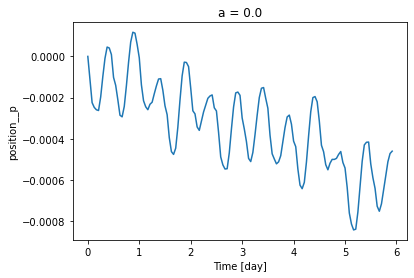

In [8]:
(x['p']-y['p']).isel(a=0).plot(x='otime_day')

# Varying Lagrangian time step $\delta t=dt$

We want to study the impact of interpolation methods and lagrangian time step on predicted trajectories.  


`norm_delta_t(DT,ODT,**args)`:  
DT: time step of time; ODT: time step of otime; args: arguments to pass to x.SetUp(args)  

We define a norm to evaluate the error $\epsilon_d$:  

$$||\epsilon_d||=\sqrt{<<\epsilon_d^2>_{4 <t<6 days}>_{a}}$$  
and we denote $\epsilon_d=p_{interpolated}-p_{uninterpolated}$ 

Nearly the same for velocity end accelaration but simulation interpolated values are compared to the analytic ones.

    $$\epsilon_{v_a}(t)=u^{interpolated}_a(t)-u^{analytic}_a(t)$$


    $$||\epsilon_v||=\sqrt{<<\epsilon_{v_a}(t)^2>_{4<t<6 jours}>_{a}}$$

    $$\epsilon_{A_a}(t)=A^{diff}_a(t)-A^{analytic}_a(t)$$

    $$||\epsilon_{acc}||=\sqrt{<<\epsilon_{A_a}(t)^2>_{4<t<6 jours}>_{a}}$$

The courant number CFL is: 
$$CFL=\frac{(U_m+U_w)\delta t}{dx}$$  

Return a dataset containing:  
As indexes:
- `delta_t` list of lagrangian time step $\delta t$
- `inter_method` the interpolation method `'Bilinéaire'` or `'Lagrange'`
- `CFL` the courant number corresponding to $\delta t$

As variables:
- `norm_x` containing $||\epsilon_d||$ for both method and for all $\delta t$ (or CFL)
- `norm_v` containing $||\epsilon_v||$ for both method and for all $\delta t$ (or CFL)
- `norm_acc` containing $||\epsilon_acc||$ for both method and for all $\delta t$ (or CFL)


In [2]:
def norm_delta_t(DT,**args):
    
    nx_liste_b=[]
    nv_liste_b=[]
    nac_liste_b=[]
    cfl_liste=[]
    T=[list(np.arange(0,sti.d2s*6, t))for t in DT]
    OT=[m[:-1]for m in T]
    x=iti.SetUp(intmethod=iti.Runge_Kutta4, **args)
    y=sti.SetUp(intmethod=sti.Runge_Kutta4, **args)
    
    for i in range(len(DT)):
        x.update_parameters(v_field__t_step=DT[i])
        x.update_clock(time=T[i], otime=OT[i])
        y.update_clock(time=T[i], otime=OT[i])
        dx=(x['p']-y['p'])**2
        nx=np.sqrt(dx.where(dx.where(dx.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nx_liste_b.append(nx)
        a=x.analytical()
        dv=(x['v']-a)**2
        nv=np.sqrt(dv.where(dv.where(dv.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nv_liste_b.append(nv)
        ac=x.analytical_acc()
        dac=(x['acc']-ac)**2
        nac=np.sqrt(dac.where(dac.where(dac.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nac_liste_b.append(nac)
        cfl_liste.append(x['CFL'])
        
    nx_liste_l=[]
    nv_liste_l=[]
    nac_liste_l=[]
    x.update_parameters(velocity__inter_method='lagrange')
    for i in range(len(DT)):
        x.update_parameters(v_field__t_step=DT[i])
        x.update_clock(time=T[i], otime=OT[i])
        y.update_clock(time=T[i], otime=OT[i])
        dx=(x['p']-y['p'])**2
        nx=np.sqrt(dx.where(dx.where(dx.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nx_liste_l.append(nx)
        a=x.analytical()
        dv=(x['v']-a)**2
        nv=np.sqrt(dv.where(dv.where(dv.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nv_liste_l.append(nv)
        ac=x.analytical_acc()
        dac=(x['acc']-ac)**2
        nac=np.sqrt(dac.where(dac.where(dac.otime<6*24*3600).otime>4*24*3600).mean('otime').mean('a'))
        nac_liste_l.append(nac)
        cfl_liste.append(x['CFL'])

    #DATASET
    ds = xr.Dataset({
        'norm_x': xr.DataArray(
            data   = np.array([nx_liste_b,nx_liste_l]).T,
            dims   = ['delta_t', 'inter_method'],
            coords = {'delta_t': DT, 'inter_method':['Bilinéaire', 'Lagrange']},
            attrs  = {'long_name': r'$||\epsilon_d||_d$','units': 'm'}),
        'norm_v':xr.DataArray(
            data   = np.array([nv_liste_b,nv_liste_l]).T,
            dims   = ['delta_t', 'inter_method'],
            coords = {'delta_t': DT, 'inter_method':['Bilinéaire', 'Lagrange']},
            attrs  = {'long_name': r'$||\epsilon_v||$','units': r'$m.s^{-1}$'}),
        'norm_acc':xr.DataArray(
            data   = np.array([nac_liste_b,nac_liste_l]).T,
            dims   = ['delta_t', 'inter_method'],
            coords = {'delta_t': DT, 'inter_method':['Bilinéaire', 'Lagrange']},
            attrs  = {'long_name': r'$||\epsilon_acc||$','units': r'$m.s^{-2}$'}),
    })
    ds.delta_t.attrs={"units":"s", "long_name":r'$\delta t$'}
    ds.coords['CFL']=cfl_liste
    ds.CFL.attrs={"units":"1", "long_name":"Courant number"}
    ds.coords['delta_t_h']=ds.delta_t/3600
    ds.delta_t_h.attrs={"units":"h", "long_name":r"$\delta t$"}
    return ds

## Advected case 

In [21]:
DT=[i*sti.h2s for i in np.linspace(0.1,7,20)]
A=norm_delta_t(DT)

In [22]:
A

<xarray.Dataset>
Dimensions:       (CFL: 20, delta_t: 20, inter_method: 2)
Coordinates:
  * delta_t       (delta_t) float64 360.0 1.667e+03 ... 2.389e+04 2.52e+04
  * inter_method  (inter_method) <U10 'Bilinéaire' 'Lagrange'
  * CFL           (CFL) float64 0.072 0.3335 0.5949 0.8564 ... 4.517 4.779 5.04
    delta_t_h     (delta_t) float64 0.1 0.4632 0.8263 1.189 ... 6.274 6.637 7.0
Data variables:
    norm_x        (delta_t, inter_method) float64 1.138 0.0007417 ... 1.925e+03
    norm_v        (delta_t, inter_method) float64 2.535e-05 ... 1.824e-08

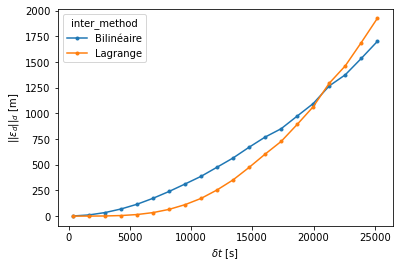

In [26]:
A.norm_x.plot(hue='inter_method', marker='.')
#plt.yscale('log')
#plt.xscale('log')

In [3]:
DT=[i*sti.h2s for i in np.linspace(0.1,18,40)]
B=norm_delta_t(DT)

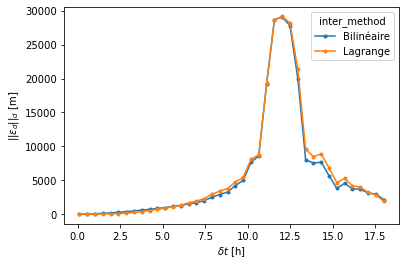

In [29]:
B.norm_x.plot(x='delta_t_h',hue='inter_method', marker='.')

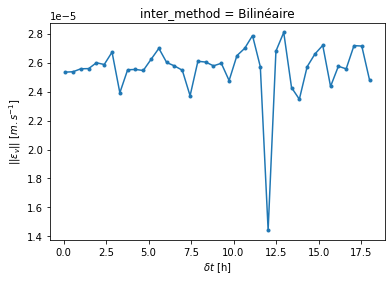

In [31]:
B.norm_v.sel(inter_method='Bilinéaire').plot(x='delta_t_h', marker='.')

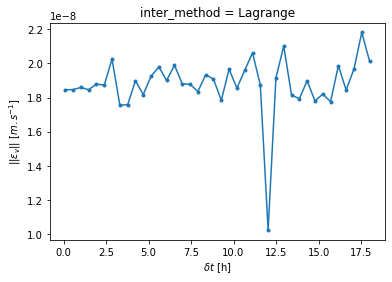

In [32]:
B.norm_v.sel(inter_method='Lagrange').plot(x='delta_t_h', marker='.')

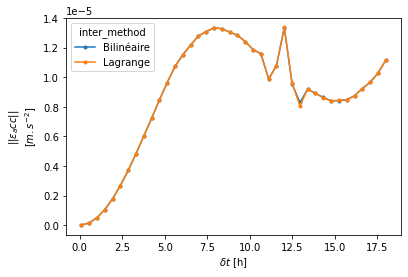

In [4]:
B.norm_acc.plot(hue='inter_method', x='delta_t_h', marker='.')